In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from network import Model

from scipy.stats import pearsonr
import json
from tools_lnd import rule_set_names, remove_ax_lines, remove_spines, remove_ticks

In [11]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','online_figs','suppfig6')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [18]:
from scipy.cluster import hierarchy
color_palette = ['b','c', 'm', 'y', 'r']
color_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                 '#e41a1c', '#dede00']
hierarchy.set_link_color_palette(color_palette)
alphabet = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 11:'k', 12:'l', 13:'m', 14:'n',
            15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t', 21:'u', 22:'v', 23:'w', 24:'x', 25:'y', 26:'z',
           27:'a', 28:'b', 29:'c', 30:'d', 31:'e', 32:'f', 33:'g', 34:'h', 35:'i', 36:'j', 37:'k', 38:'l', 39:'m', 
            40:'n', 41:'o', 42:'p', 43:'q', 44:'r', 45:'s', 46:'t', 47:'u', 48:'v', 49:'w', 50:'x', 51:'y', 52:'z'}

def make_cluster_midpoint_labels(clust):
    d = np.concatenate(([-1], np.where(np.diff(clust))[0],[len(clust)-1]),axis = 0)
    mid = np.zeros(len(d))
    cluster_size = np.zeros(len(d))
    for xi in range(len(d)-1):
        cluster_size[xi] = d[xi+1] - d[xi]
        mid[xi] = d[xi+1]-cluster_size[xi]/2+.5
    return cluster_size, mid

task_name_dict = {}
task_name_dict['Go'] = rule_set_names[0]
task_name_dict['RT Go'] = rule_set_names[1]
task_name_dict['Dly Go'] = rule_set_names[2]
task_name_dict['Anti'] = rule_set_names[3]
task_name_dict['RT Anti'] = rule_set_names[4]
task_name_dict['Dly Anti'] = rule_set_names[5]
task_name_dict['Dly DM 1'] = rule_set_names[6]
task_name_dict['Dly DM 2'] = rule_set_names[7]
task_name_dict['Ctx Dly DM 1'] = rule_set_names[8]
task_name_dict['Ctx Dly DM 2'] = rule_set_names[9]
task_name_dict['MultSen Dly DM'] = rule_set_names[10]
task_name_dict['DMS'] = rule_set_names[11]
task_name_dict['DNMS'] = rule_set_names[12]
task_name_dict['DMC'] = rule_set_names[13]
task_name_dict['DNMC'] = rule_set_names[14]

In [20]:
def plot_epoch_labels(ax, epoch_binary, which_axes = 'y', ms = .9):
    
    e_set = ['stim1','stim2','delay1','delay2','go1']
    e_color = plt.get_cmap('terrain')

    yl = np.max(ax.get_ylim())+2
    xl = np.max(ax.get_xlim())+2
    
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        where = np.where(epoch_binary[e_name])[0]-.7
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            ax.plot(np.where(epoch_binary[e_name])[0],
                     yl*np.ones(np.sum(epoch_binary[e_name])),'s',
                     color = c,markersize = ms,label = e_name)

            for w in where:
            
                rect = patches.Rectangle((w, yl), 1, 3,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
        if 'x' in which_axes:
            
            ax.plot(xl*np.ones(np.sum(epoch_binary[e_name])),
                     np.where(epoch_binary[e_name])[0],'s',
                     color = c,markersize = ms,label = e_name)
            
            for w in where:
                rect = patches.Rectangle((xl, w), 3, 1,linewidth=ms, edgecolor=c, facecolor=c)
                ax.add_patch(rect)
            
            
def plot_epoch_rects(ax, epoch_binary, e_set, which_axes = 'y', rect_height = 1, rect_width = 58, ll = []):
    e_color = plt.get_cmap('terrain')

    if len(ll)>0:
        xl = ll[1]
        yl = ll[0]
    else:
        yl = np.max(ax.get_ylim())+2
        xl = np.max(ax.get_xlim())+2

        
    for ei in range(len(e_set)):
        e_name = e_set[ei]
        c = e_color(ei/len(e_set))
        
        if 'y' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((ind-.5,yl),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
            
        if 'x' in which_axes:
            
            for ind in np.where(epoch_binary[e_name])[0]:
                rect=mpatches.Rectangle((xl,ind-.5),rect_height,rect_width,
                                        fill=True,color=c,facecolor=c,alpha = .3,clip_on=False)
                plt.gca().add_patch(rect)
        

In [14]:
# set of networks to compare
rnn_type_set = ['LeakyRNN','LeakyGRU']
activation_set = ['softplus','tanh','retanh']
w_init_set = ['diag','randgauss']

seed_set = [str(0),str(1),]
max_d = 3.5
n_rnn = str(128)
x_ind_counter = 0
ax1_xticks = []
method = 'ward'
all_epochs = ['stim1','stim2','delay1','delay2','go1']

n_rnn = 128
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 1
lr = -6
sigma_rec = 1/20
sigma_x = 2/20
pop_rule = 5
ruleset = 'all'
w_rec_coeff  = 8/10

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

method = 'ward'
criterion = 'distance'
cel_max_d = '3.5'

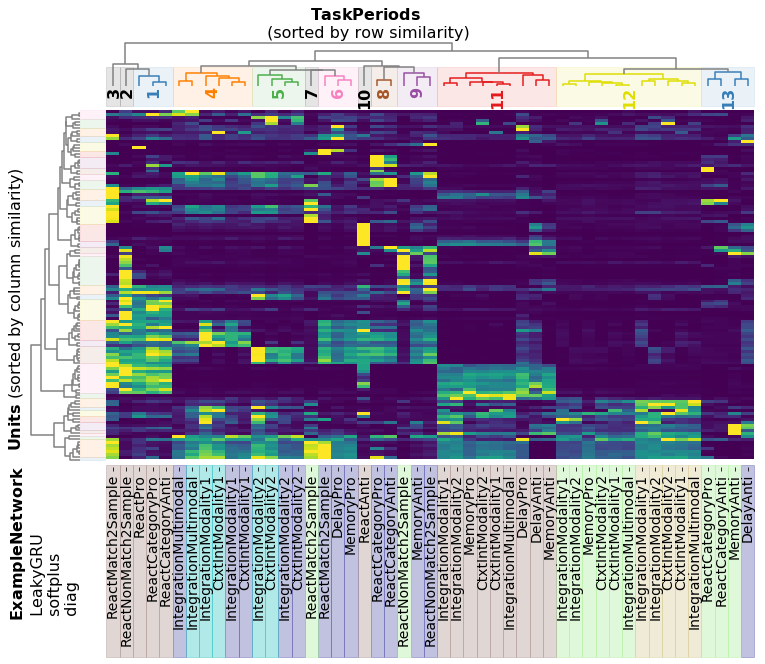

In [24]:
### load master network and make average correlation matrix across seeds

data_folder_set = ['final1',]
data_folder=data_folder_set[0]

# ########################
# ######supp examples######
rnn_type = 'LeakyGRU'
activation = 'softplus'
w_init = 'diag'
seed = 0
# # ########################
# rnn_type = 'LeakyGRU'
# activation = 'tanh'
# w_init = 'diag'
# seed = 0
# ########################
# rnn_type = 'LeakyRNN'
# activation = 'tanh'
# w_init = 'randgauss'
# seed = 0
# # ########################
# rnn_type = 'LeakyRNN'
# activation = 'retanh'
# w_init = 'randgauss'
# seed = 0
# # ########################

import matplotlib.patches as mpatches

# x-axis and labelling bs
if data_folder==data_folder_set[0]:
    x_ind_counter+=1
    label = ' '.join([rnn_type,activation,w_init])
    if len(ax1_xticks)==0:
        ax1_xticks = [label,]
    else:
        ax1_xticks.append(label)


if data_folder=='no_noise':
    l2w = -0
    l2h = -0
else:
    l2w = -6
    l2h = -6

if (rnn_type == 'LeakyRNN') & (activation == 'tanh') & (data_folder == 'final1'):
    w_rec_coeff  = 1
    lr = -8
else:
    w_rec_coeff  = 8/10
    lr = -6

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)

net_name2 = '_sig_rec'+str(sigma_rec)+'_sig_x'+str(sigma_x)+'_w_rec_coeff'+"{:.1f}".format(w_rec_coeff)+'_'+rule_trains_str

m_master = os.path.join(p,'data','rnn','multitask',net,'final1',ruleset,
                        rnn_type,activation,w_init,str(len(rule_trains))+'_tasks',
                        str(n_rnn)+'_n_rnn',net_name+net_name2,str(seed))
label_master = ' '.join([rnn_type,activation,w_init,str(seed)])

lesion_folder = 'lesion_fps_hierarchical_ward_maxclust_opt_clust'
save_dir = os.path.join(m_master,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names']

feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
epoch_binary = {}
for e_name in ['delay1','delay2','go1','stim1','stim2']:
    epoch_binary[e_name] = [feat_name.rsplit(' ', 1)[-1]==e_name for 
                            feat_name in feature_names_master]

D = cluster_var['D'].T
feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]

feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
X = D[:,feat_order]
#     X = D

#visualize atlas for master network
fig = plt.figure(figsize=(18,9))
plt.rcParams.update({'font.size': 16})
legend_done = 0
atlas_width = .55
atlas_height = .55
thresh = 4

axdendro_top = fig.add_axes([.06,atlas_height+.082,atlas_width-.05,.07])
Y = sch.linkage(X.T, method=method)
clusters_top = fcluster(Y, thresh, criterion=criterion)
Z_top = sch.dendrogram(Y, orientation='top',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=thresh,
                          above_threshold_color='gray', labels = clusters_top)

cluster_size,mid_top = make_cluster_midpoint_labels(clusters_top)
for xi in range(len(mid_top)-1):
    if cluster_size[xi]==1:
        c = 'k'
    else:
        color_ind = xi - np.sum(cluster_size[:xi]==1)
        c = color_palette[color_ind%len(color_palette)]
    clust_mid = mid_top[xi]
    rect=mpatches.Rectangle((5+10*(clust_mid-cluster_size[xi]/2),-5),cluster_size[xi]*10,10, 
    fill=True,color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)
    plt.text(clust_mid*10,-3,str(clusters_top[int(clust_mid)]),color=c,fontweight='bold',rotation = 90)

remove_spines(axdendro_top)
remove_ticks(axdendro_top)
axdendro_top.set_xticks([])

axdendro = fig.add_axes([0,.054,0.04,atlas_height*.98])
Y = sch.linkage(X, method=method)
clusters = cluster_var['clusters']
Z = sch.dendrogram(Y, orientation='left',#labels = clusters, #CA.ind_active #clusters
                   leaf_font_size = 11,color_threshold=0,above_threshold_color='gray', labels = clusters)

cluster_size, mid = make_cluster_midpoint_labels(clusters)
for xi in range(len(mid)-1):

    c = color_palette[xi%len(color_palette)]
    clust_mid = mid[xi]
    rect=mpatches.Rectangle((-5,10+10*(clust_mid-cluster_size[xi]/2)),5,cluster_size[xi]*10, 
    fill=True,
    color=c,facecolor=c,alpha = .1,clip_on=False)
    plt.gca().add_patch(rect)

remove_spines(axdendro)
remove_ticks(axdendro)
axdendro.set_xticks([])


axmatrix = fig.add_axes([.06,0.045,atlas_width-.05,atlas_height])#fig.add_subplot(1,2,1)
index_top = Z['leaves']
X = X[index_top,:]
plt.imshow(X[-1:0:-1,:],cmap= 'viridis', aspect='auto')

len_te = len(feature_names_labels)
axmatrix.set_xticks(range(len_te))
task_labels = [task_name_dict[feat] for feat in feature_names_labels]
axmatrix.set_xticklabels(task_labels,fontsize = 14, rotation =90,ha = 'center')
plot_epoch_rects(axmatrix,epoch_binary,all_epochs,which_axes = 'y', rect_height = 1, rect_width = 65)

label_master_seed = ' '.join([rnn_type,activation,w_init]) 

plt.text(-8,len(X)/5,r"$\bf{Units}$"+' (sorted by column similarity)',rotation = 90)
plt.text(-8,1.2*len(X),r"$\bf{Example Network}$"+ ' \n '+' \n '.join(label_master_seed.split()),rotation = 90)
axmatrix.set_xlabel(r"$\bf{Task Periods}$"+ ' \n (sorted by row similarity)')
axmatrix.xaxis.set_label_coords(.4, 1.29)
remove_spines(axmatrix)
axmatrix.set_yticks([])
plt.ylim((len(X)+1,0))

# make subpanels.
sp_width = .14
sp_wide = .2
offset = .06

label = '_'.join([data_folder,rnn_type,activation,w_init,str(seed)])
figname = 'atlas_'+label+'.pdf'
figpath_full = os.path.join(figpath,'atlas',data_folder)
if not os.path.exists(figpath_full):
    os.makedirs(figpath_full)
plt.savefig(os.path.join(figpath_full,figname),bbox_inches = 'tight')

plt.show()